### Análisis de valores extremos (outliers) en PM2.5

Con el objetivo de identificar eventos de contaminación severa en Monterrey, se realizó un análisis de valores atípicos en la concentración de PM2.5.

Inicialmente se probaron enfoques estadísticos como el IQR y el percentil 95, los cuales arrojaron límites (~51 µg/m³ y ~48 µg/m³) que resultaron poco representativos de la realidad local. En ciudades como Monterrey, es común observar concentraciones superiores durante episodios específicos.

Por ello, se optó por utilizar un **umbral contextual de 100 µg/m³**, más alineado con criterios de alerta ambiental. También se representa visualmente la línea de la **norma oficial mexicana (NOM-025-SSA1-2021)** que establece un límite de 45 µg/m³ para exposiciones de 24 horas.


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
registros_filtrados = pd.read_excel("registros_filtrados.xlsx")

print(registros_filtrados.shape)
registros_filtrados.head()


(786656, 17)


,Registros_id,Dia,PM10,PM25,O3,CO,NO1,NO2,NOx,SO2,Sensor_id,TEMPERATURA,LLUVIA,PRESIONATM,HUMEDAD,RS,VIENTOVEL
0,2440510,2025-04-04,65.0,23.52,0.056,NaN,0.0033,0.0120,0.0151,0.0047,ANL1,37.92,0.0,712.9,17.0,0.138,15.3
1,2440511,2025-04-04,132.0,NaN,0.035,NaN,0.0467,0.0271,0.0737,0.0046,ANL10,38.37,0.0,701.2,10.0,0.198,12.1
2,2440512,2025-04-04,38.0,31.00,0.063,0.44,0.0028,0.0083,0.0111,0.0106,ANL11,0.00,0.0,701.9,14.0,0.186,18.4
3,2440513,2025-04-04,50.0,NaN,0.056,1.31,0.0045,0.0168,0.0215,0.0059,ANL12,36.75,0.0,702.1,15.0,0.145,16.3
4,2440514,2025-04-04,53.0,16.00,0.061,0.52,NaN,0.0032,0.0056,0.0047,ANL13,38.88,0.0,717.8,16.0,0.053,12.3


In [3]:
# Eliminar valores negativos de PM2.5 para análisis estadístico
pm25_validos = registros_filtrados[registros_filtrados["PM25"] >= 0].copy()
pm25 = pm25_validos["PM25"].dropna()

Q1 = pm25.quantile(0.25)
Q3 = pm25.quantile(0.75)
IQR = Q3 - Q1

limite_superior = Q3 + 1.5 * IQR

print(f"Nuevo Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"Límite superior actualizado: {limite_superior:.2f}")
umbral_p95 = pm25.quantile(0.95)
print(f"Percentil 95: {umbral_p95:.2f}")



Nuevo Q1: 10.52, Q3: 27.00, IQR: 16.48
Límite superior actualizado: 51.72
Percentil 95: 48.74


In [4]:
### Outliers por sensor
registros_filtrados["outlier_pm25"] = (
    (registros_filtrados["PM25"] < 0) |
    (registros_filtrados["PM25"] > limite_superior)
)
outliers_por_sensor = registros_filtrados.groupby("Sensor_id")["outlier_pm25"].sum().sort_values(ascending=False)

# Mostrar los sensores con más outliers
print("Sensores con más outliers en PM2.5:")
print(outliers_por_sensor.head(10))

Sensores con más outliers en PM2.5:
Sensor_id
ANL13    3474
ANL3     3464
ANL10    2128
ANL12    2050
ANL5     1949
ANL7     1681
ANL2     1635
ANL8     1589
ANL6     1414
ANL4     1021
Name: outlier_pm25, dtype: int64


Se visualizan los datos de PM2.5 a lo largo del tiempo, destacando:
- Eventos extremos que superan los 100 µg/m³ en rojo
- Datos dentro de rangos normales en azul
- Líneas de referencia estadística y normativa

Esto permite observar picos importantes en años como 2019, 2022 y 2023, posiblemente vinculados a condiciones ambientales, climáticas o actividades industriales.

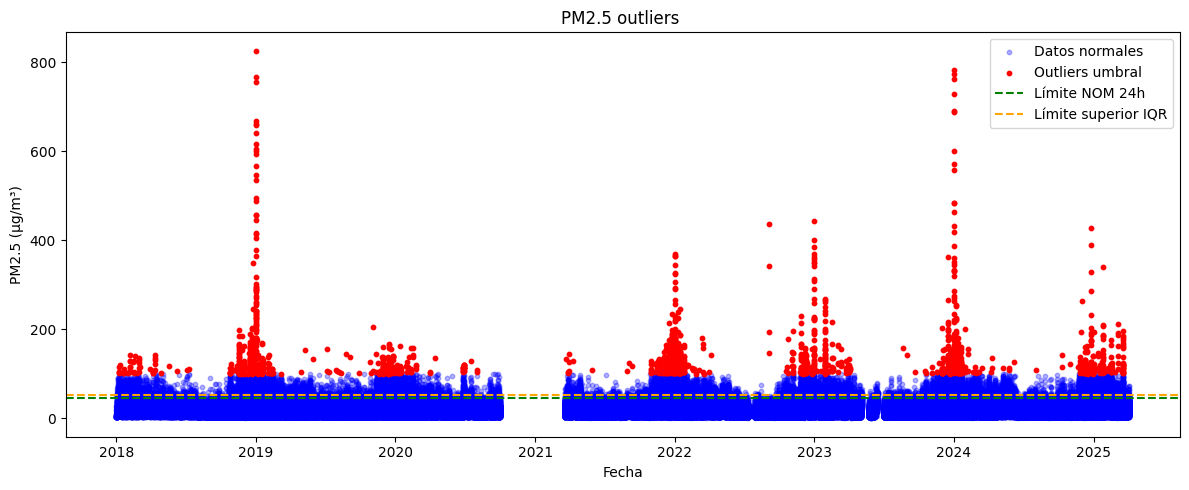

In [5]:
pm25_validos["outlier_pm25"] = pm25_validos["PM25"] > 100

normales = pm25_validos[pm25_validos["outlier_pm25"] == False]
outliers = pm25_validos[pm25_validos["outlier_pm25"] == True]

plt.figure(figsize=(12, 5))

plt.scatter(normales["Dia"], normales["PM25"], alpha=0.3, s=10, color="blue", label="Datos normales")
plt.scatter(outliers["Dia"], outliers["PM25"], color="red", s=10, label="Outliers umbral")

plt.axhline(45, color="green", linestyle="--", label="Límite NOM 24h")
plt.axhline(limite_superior, color="orange", linestyle="--", label="Límite superior IQR")

plt.title("PM2.5 outliers ")
plt.xlabel("Fecha")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.tight_layout()
plt.show()



### Conclusión

El análisis sugiere que usar criterios puramente estadísticos para detectar outliers en contaminación no es suficiente cuando se estudia una ciudad con altos niveles como Monterrey. Es necesario considerar límites sanitarios y el contexto ambiental.

La elección de un umbral basado en política pública (100 µg/m³) permitió distinguir eventos de alta contaminación sin descartar datos válidos. Esta clasificación será útil en el análisis de patrones geográficos y temporales, así como para la evaluación de políticas de mitigación.